In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
class PCAcls():
   
    ###############

    def __init__ (self, a = 30): # a=0.9
        '''
        Constructor: function called every time a PCA object is initialized
        '''
        # if 0<=a<1, 'a' indicates the desired explained variance fraction
        # if a>=1, 'a' indicates the desired number of components
        self.a = a
   
    ###############

    def fit(self, X, conf_Q = 0.99, conf_T2 = 0.99, plot = True):
        '''
        Model training function
        '''
        # storing training averages and standard deviations
        self.mu_train = X.mean(axis=0)
        self.std_train = X.std(axis=0)
       
        # normalizing training data
        X = np.array(((X - self.mu_train)/self.std_train))
       
        # calculating the covariance matrix of the data
        #Cx = np.cov(X, rowvar=False)
        pca = PCA(n_components = self.a) # self.a
        pcat = pca.fit_transform(X)
        
        # applying decomposition into eigenvalues ​​ and eigenvectors
        #self.L, self.P = np.linalg.eig(Cx)
        self.L = pca.explained_variance_
        self.P = -(pca.components_.T)
        
        # fractions of explained variance
        fv = self.L/np.sum(self.L)
        
        # fractions of accumulated explained variance
        fva = np.cumsum(self.L)/sum(self.L)
       
        # defining number of components
#         if self.a>0 and self.a<1:
#             self.a = np.where(fva>self.a)[0][0]+1
            
        # calculating detection limits

        # limit of the T^2 statistic
        from scipy.stats import f
        F = f.ppf(conf_T2, self.a, X.shape[0]-self.a)
        self.T2_lim = ((self.a*(X.shape[0]**2-1))/(X.shape[0]*(X.shape[0]-self.a)))*F
        
        # Q statistic limit
#         theta = [np.sum(self.L[self.a:]**(i)) for i in (1,2,3)]
#         ho = 1-((2*theta[0]*theta[2])/(3*(theta[1]**2)))
#         from scipy.stats import norm
#         nalpha = norm.ppf(conf_Q)
#         self.Q_lim = (theta[0]*(((nalpha*np.sqrt(2*theta[1]*ho**2))/theta[0])+1+
#                                 ((theta[1]*ho*(ho-1))/theta[0]**2))**(1/ho))
        
        # plotting explained variances
        if plot:
            fig, ax = plt.subplots()
            ax.bar(np.arange(len(fv)),fv)
            ax.plot(np.arange(len(fv)),fva)
            ax.set_xlabel('Number of components')
            ax.set_ylabel('Data variance')
            ax.set_title('PCA - Variance Explained');

    ###############
            
    def predict(self, X):
        '''
        Function for model testing
        '''
            
        # normalizing test data (using training parameters!)
        X = np.array((X - self.mu_train)/self.std_train)

        # calculating T^2 statistic
        T = X@self.P[:,:self.a]
        self.T2 = np.array([T[i,:]@np.linalg.inv(np.diag(self.L[:self.a]))@T[i,:].T for i in range (X.shape[0])])

        # calculating Q statistic
#         e = X - X@self.P[:,:self.a]@self.P[:,:self.a].T
#         self.Q = np.array([e[i,:]@e[i,:].T for i in range(X.shape[0])])
        
        # calculating contributions to Q
#         self.c = np.absolute(X*e)
                
    ###############

    def plot_control_charts(self, fault = None):
        '''
        Function to plot control charts
        '''
        fig, ax = plt.subplots(1,2, figsize=(15,3))

        ax[0].semilogy(self.T2,'.')
        ax[0].axhline(self.T2_lim,ls='--',c='r');
        ax[0].set_title('Control Letter $T^2$')
        
#         ax[1].semilogy(self.Q,'.')
#         ax[1].axhline(self.Q_lim,ls='--',c='r')
#         ax[1].set_title('Q Control Letter')
 
        if fault is not None:
            ax[0].axvline(fault, c='k')
            ax[1].axvline(fault, c='k')

    ###############
            
#     def plot_contributions(self, fault = None,
#                            index = None,
#                            columns = None):
#         '''
#         Function to plot contribution maps
#         '''
#         fig, ax = plt.subplots(figsize=(20, 6))
        
#         c = pd.DataFrame(self.c,
#                          index = index,
#                          columns = columns)
    
#         sns.heatmap(c, ax = ax,
#                     yticklabels=int(self.c.shape[0]/10),
#                     cmap = plt.cm.Blues);
        
#         ax.set_title('Partial contributions to Q')
        
#         if fault is not None:
#             ax.axhline(y=c.index[fault],
#                        ls='--', c='k')

In [5]:
df_train = train_normal[(train_normal.simulationRun>=1)&
                                 (train_normal.simulationRun<5)].iloc[:,3:]

df_test = train_normal[(train_normal.simulationRun>5)&
                                (train_normal.simulationRun<10)].iloc[:,3:]

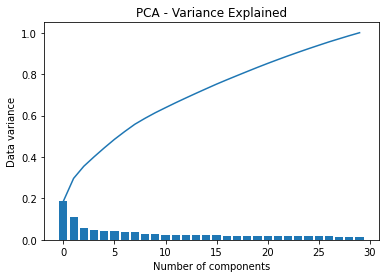

In [6]:
pca = PCAcls()
pca.fit(df_train)

In [7]:
pca.a

30

In [8]:
pca.predict(df_test)

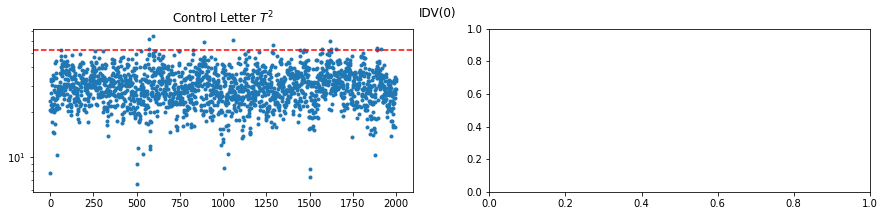

In [9]:
pca.plot_control_charts()
plt.suptitle('IDV(0)');

In [10]:
print('False alarm rate\n--------------')

print(f'T2: {(pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]}')
# print(f'Q: {(pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]}')

False alarm rate
--------------
T2: 0.0085


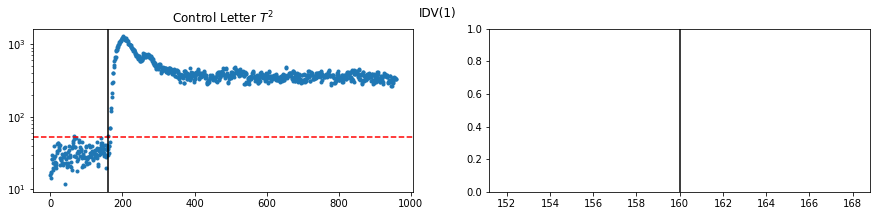

In [11]:
IDV = 1

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

# pca.plot_contributions(fault=160, columns = df_test.columns)

In [12]:
print(f'Failure Detection Rates - IDV({IDV})\n--------------')

print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')
# print(f'Q: {(pca.Q[160:]>pca.Q_lim).sum()/pca.Q[160:].shape[0]}')

Failure Detection Rates - IDV(1)
--------------
T2: 0.99375


Failure Detection Rates - IDV(2)
--------------
T2: 0.985


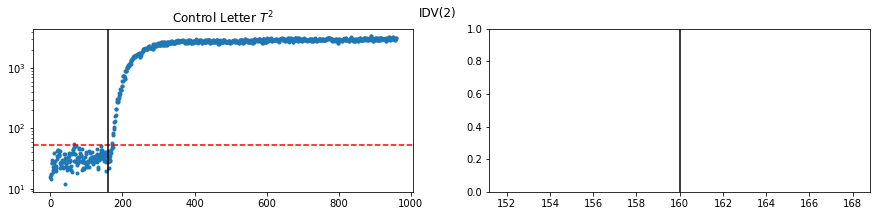

In [13]:
IDV = 2

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(3)
--------------
T2: 0.01


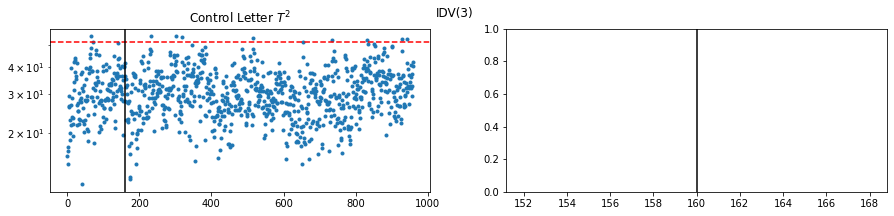

In [14]:
IDV = 3

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(4)
--------------
T2: 0.33125


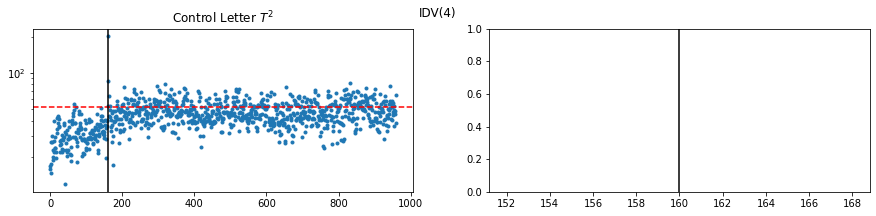

In [15]:
IDV = 4

df_test = test_faulty[(test_faulty.faultNumber==IDV) &
                                (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

# pca.plot_contributions(fault=160, columns = df_test.columns)

print(f'Failure Detection Rates - IDV({IDV})\n--------------')

print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')
# print(f'Q: {(pca.Q[160:]>pca.Q_lim).sum()/pca.Q[160:].shape[0]}')

Failure Detection Rates - IDV(5)
--------------
T2: 0.25


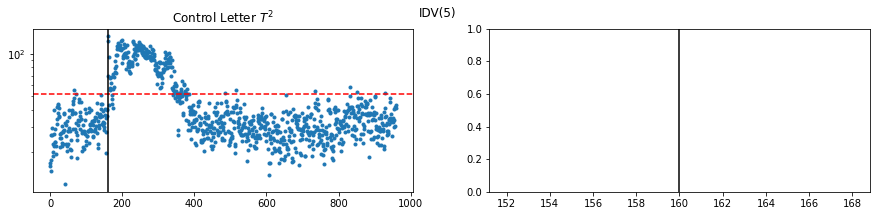

In [16]:
IDV = 5

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(6)
--------------
T2: 0.99


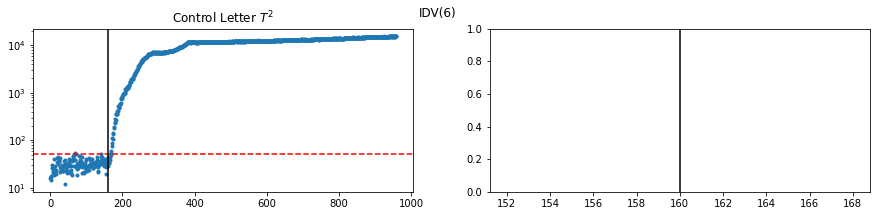

In [17]:
IDV = 6

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(7)
--------------
T2: 1.0


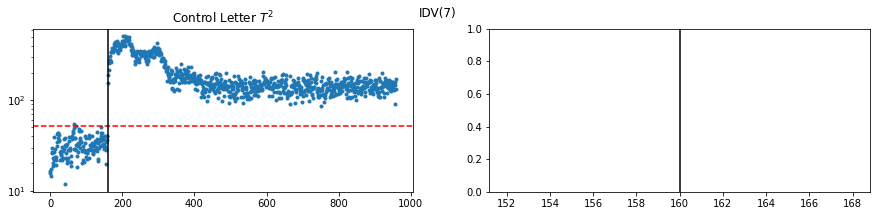

In [18]:
IDV = 7

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(8)
--------------
T2: 0.975


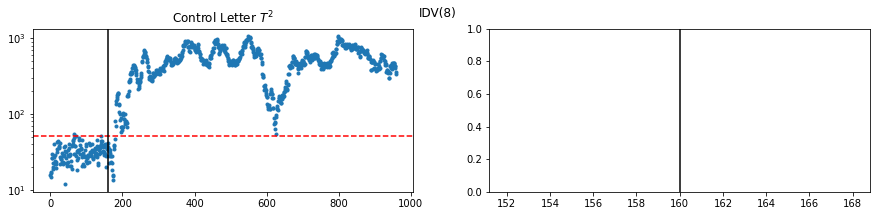

In [19]:
IDV = 8

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(9)
--------------
T2: 0.01125


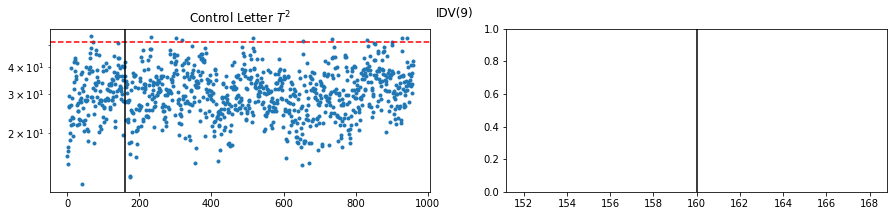

In [20]:
IDV = 9

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(10)
--------------
T2: 0.0525


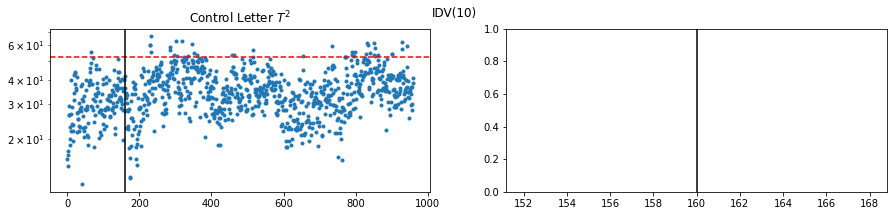

In [21]:
IDV = 10

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(11)
--------------
T2: 0.4275


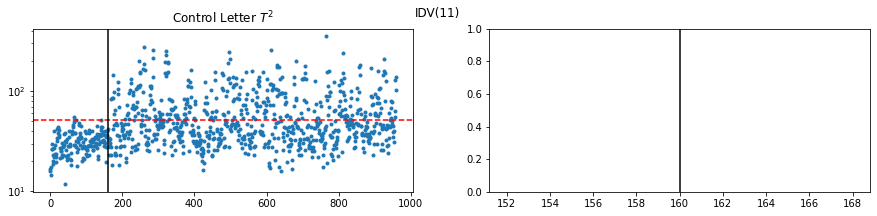

In [22]:
IDV = 11

df_test = test_faulty[(test_faulty.faultNumber==IDV) &
                                (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

# pca.plot_contributions(fault=160, columns = df_test.columns)

print(f'Failure Detection Rates - IDV({IDV})\n--------------')

print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(12)
--------------
T2: 0.97375


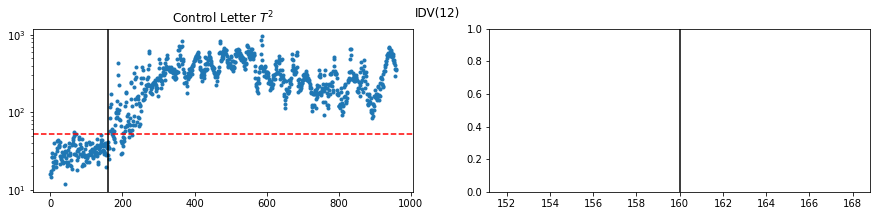

In [23]:
IDV = 12

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(13)
--------------
T2: 0.91625


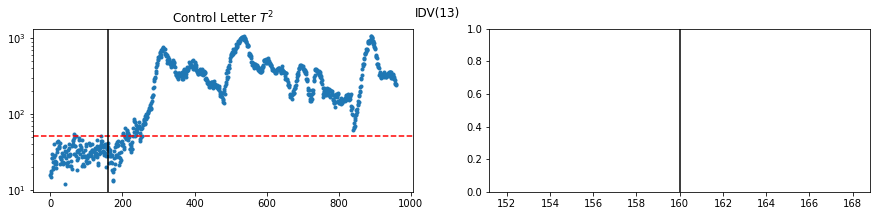

In [24]:
IDV = 13

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(14)
--------------
T2: 0.995


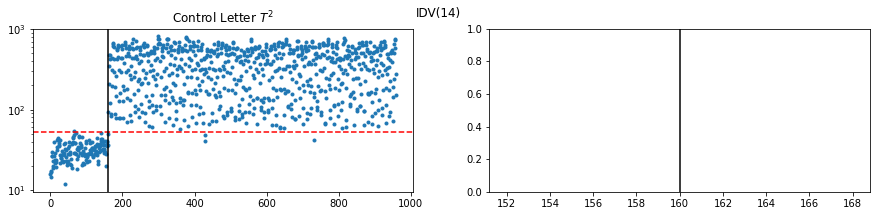

In [25]:
IDV = 14

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(15)
--------------
T2: 0.01125


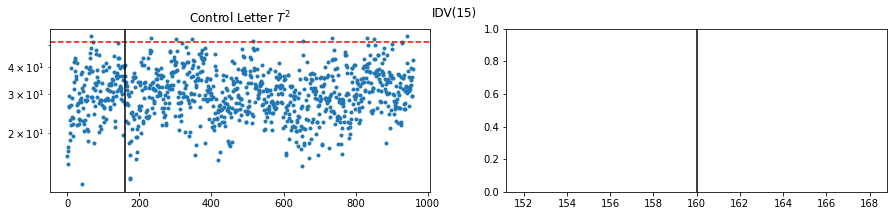

In [26]:
IDV = 15

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(16)
--------------
T2: 0.04125


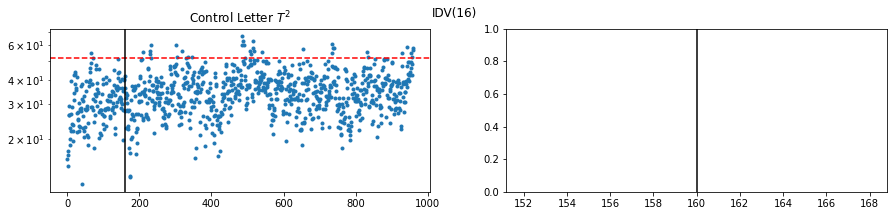

In [27]:
IDV = 16

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(17)
--------------
T2: 0.69375


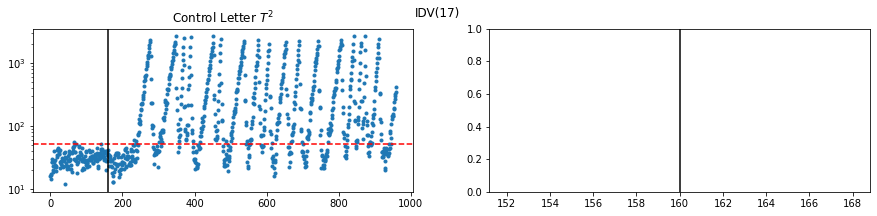

In [28]:
IDV = 17

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(18)
--------------
T2: 0.92


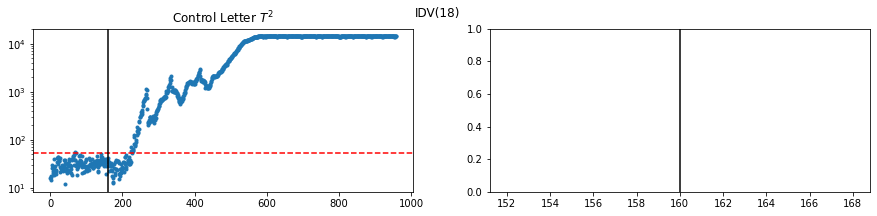

In [29]:
IDV = 18

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(19)
--------------
T2: 0.1075


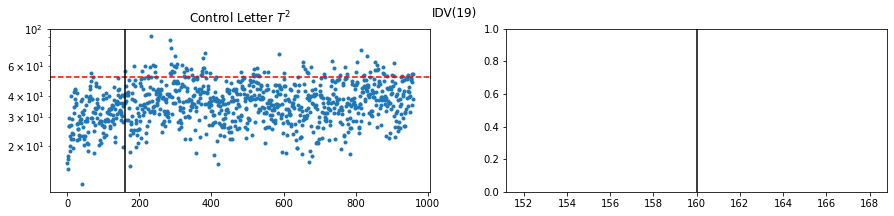

In [30]:
IDV = 19

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

Failure Detection Rates - IDV(20)
--------------
T2: 0.1975


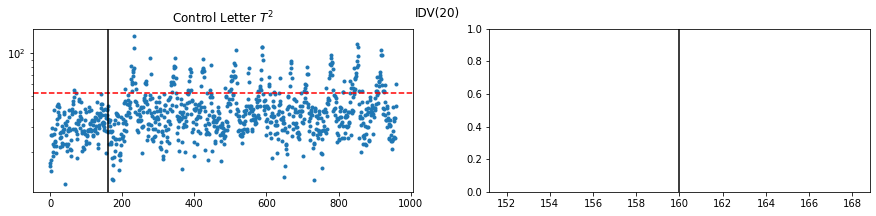

In [31]:
IDV = 20

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(df_test)

pca.plot_control_charts(fault=160)
plt.suptitle(f'IDV({IDV})');

print(f'Failure Detection Rates - IDV({IDV})\n--------------')
# pca.plot_contributions(fault=160, columns = df_test.columns)
print(f'T2: {(pca.T2[160:]>pca.T2_lim).sum()/pca.T2[160:].shape[0]}')

In [32]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged 

Taxas de detecção de falhas - IDV(11)
--------------
T2: 0.1875


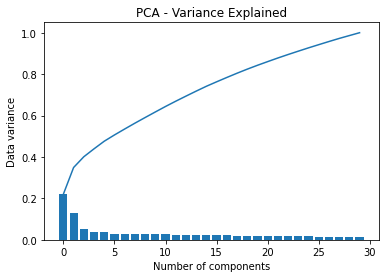

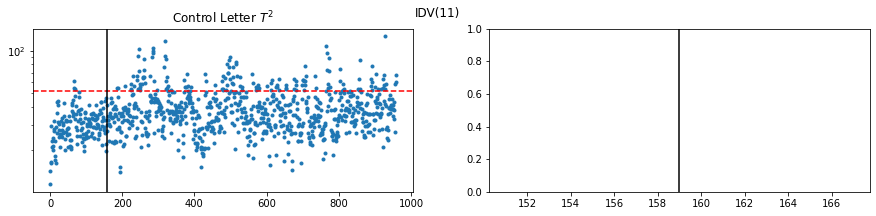

In [33]:
lag = 1

pca.fit(apply_lag(df_train, lag=lag))

IDV = 11

df_test = test_faulty[(test_faulty.faultNumber==IDV) & 
                               (test_faulty.simulationRun==1)].iloc[:,3:]

pca.predict(apply_lag(df_test, lag=lag))

pca.plot_control_charts(fault=160-lag)
plt.suptitle(f'IDV({IDV})');

# pca.plot_contributions(fault=160-lag, columns = apply_lag(df_test, lag=lag).columns)

print(f'Taxas de detecção de falhas - IDV({IDV})\n--------------')

print(f'T2: {(pca.T2[160-lag:]>pca.T2_lim).sum()/pca.T2[160-lag:].shape[0]}')